In [1]:
import sys
!pip install sympy==1.5.1
import sympy
print(sympy.__version__)

     |████████████████████████████████| 5.6MB 2.8MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1
1.5.1


In [0]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
x, hbar, w, t = symbols("x, hbar, w, t")

In [0]:
class SHO:
    # Class SHO
    # This class recieve a 1-dim'l function as a string(need not be normalized)
    # and analyze the function in the SHO basis

    # Private methods
    def __init__(self, psi):
        # primitive store the ground state of SHO
        # psi store the wave function to analyze in the energy basis of SHO
        # If you just want to analyze with basis, no need input wave function
        # Declare the class as
        # model = SHO("")

        print("[SHO] 초기설정 시간 좀 걸려요ㅠ")
        self.__primitive = pi**(-1/4) * exp(-x**2/2)
        self.psi = psi
        if self.psi:
            self.psi = self.__Normalize(sympify(self.psi))
        self.__basis = []
        for i in range(30):
            if i == 0:
                self.__basis.append(self.__primitive)
            else:
                temp = self.Raise(self.__basis[i-1], i-1)
                self.__basis.append(temp.simplify())
        print("[SHO] SHO is prepared")


    def __Normalize(self, expr):
        # 1 = A^*A<psi|psi>
        # Get A and updaate psi

        norm = integrate(expr*expr, (x, -oo, oo))
        expr = expr / sqrt(norm)
        return expr.simplify()

    def __Pos(self, expr):
        # X(psi) = x*psi

        temp = x * expr
        return temp.simplify()

    def __Mom(self, expr):
        # P(psi) = -id(psi)/dx

        temp = -I * diff(expr)
        return temp.simplify()

    def __Raising(self, basis):
        # a^+ = (-ip + x)/sqrt(2)

        temp1 = -I * self.__Mom(basis)
        temp2 = self.__Pos(basis)
        temp = (1/sqrt(2)) * (temp1 + temp2)
        return temp.simplify()

    def __Lowering(self, basis):
        # a = (ip + x)/sqrt(2)

        temp1 = I * self.__Mom(basis)
        temp2 = self.__Pos(basis)
        temp = (1/sqrt(2)) * (temp1 + temp2)
        return temp.simplify()

    def __Hamiltonian_ladder(self, expr):
        # H = hbar*w(a^+a + 1/2)

        temp1 = self.__Lowering(basis)
        temp1 = self.__Raising(temp1)
        temp1 *= hbar * w
        temp2 = hbar*w*(1/2)*basis
        temp = temp1 + temp2
        return temp.simplify()

    def __Hamiltonian_xp(self, expr):
        # H = (hbar*w /2)*(p^2 + x^2)

        temp1 = self.__Mom(self.__Mom(expr))
        temp2 = self.__Pos(self.__Pos(expr))
        temp = (hbar*w/2)*(temp1 + temp2)
        return temp.simplify()

    def __InnerProduct(self, expr1, expr2):
        # <f_1|f_2>

        expr1 = conjugate(expr1)
        temp = integrate(expr1*expr2, (x, -oo, oo))
        return temp.simplify()

    # Public methods
    def InnerProduct(self, expr1, expr2):
        # <f_1|f_2>

        expr1 = conjugate(expr1)
        temp = integrate(expr1*expr2, (x, -oo, oo))
        return temp.simplify()
    
    def Raise(self, basis, n):
        # psi_n+1 = a^+psi_n / sqrt(n+1)

        temp = self.__Raising(basis)
        temp /= sqrt(n+1)
        return temp.simplify()

    def Lower(self, basis, n):
        # psi_n-1 = a psi_n / sqrt(n)

        temp = self.__Lowering(basis)
        temp /= sqrt(n)
        return temp.simplify()

    def GetBasis(self, n):
        # psi_n = (a^+)^n psi_0 / sqrt(n!)

        if (n < 30):
            return self.__basis[n]
        else:
            temp = self.GetBasis(n-1)
            return temp.simplify()

    def GetNumber(self, basis):
        # N psi_n = n psi_n
        # return n

        temp = self.__Lowering(basis)
        temp = self.__Raising(temp)
        return temp.simplify() / basis

    def GetEnergy(self, basis):
        # H psi_n = (n+1/2)*hbar*w
        # return E_n = (n+1/2)*habr*w

        temp = self.__Hamiltonian_xp(basis)
        temp /= basis
        return temp.simplify()

    def CheckOrtho(self, n, m):
        # <n|m> = delta_{nm}

        psi_n = self.GetBasis(n)
        psi_m = self.GetBasis(m)
        result = self.__InnerProduct(psi_n, psi_m)
        return result.simplify()

    def GetCoeff(self, n):
        # c_n = <psi_n|psi>

        if self.psi:
            psi_n = self.GetBasis(n)
            expr = self.psi
            coeff = self.__InnerProduct(psi_n, expr)
            return coeff.simplify()
        else:
            print("Input wave function is not defined")
            sys.exit(1)            

    def GetProb(self, n):
        # P(psi->psi_n) = |c_n|^2

        if self.psi:
            expr = self.psi
            coeff = self.GetCoeff(n, expr)
            prob = conjugate(coeff)*coeff
            return prob.simplify()
        else:
            print("Input wave function is not defined")
            sys.exit(1)

    def GetExpectEnergy(self):
        # E = <H> = <psi|H|psi>

        if self.psi:
            expr = self.psi
            temp = self.__Hamiltonian_xp(expr)
            expect = self.__InnerProduct(expr, temp)
            return expect.simplify()
        else:
            print("Input wave function is not defined")
            sys.exit(1)

    # Plotting tools
    def PlotBasis(self, n, xrange, marker, title, label):
        # Plot the basis functions for the SHO

        psi_n = self.GetBasis(n)
        X = np.arange(-xrange, xrange, 0.01)
        Y = []
        for i in range(X.size):
            Y.append(psi_n.subs(x, X[i]))
        Y = np.array(Y)
        plt.plot(X, Y, marker, label = label)
        plt.xlim(-xrange, xrange)
        plt.xlabel("x")
        plt.ylim(-1, 1)
        plt.ylabel("psi")
        plt.title(title)
        plt.grid(True)
        plt.legend(loc = 0)
        job_prefix = "[Job Status] Plotting "
        job_suffix = " state finished."
        if n == 0:
            print(job_prefix + "ground" + job_suffix)
        elif n == 1:
            print(job_prefix + "1st excited" + job_suffix)
        elif n == 2:
            print(job_prefix + "2nd excited" + job_suffix)
        elif n==3:
            print(job_prefix + "3rd excited" + job_suffix)
        else:
            print(job_prefix + str(n) + "th excited" + job_suffix)

In [0]:
class TimeEvolution(SHO):
    # class TimeEvolution
    # Inherited from class SHO
    # Evaluate time evolution operator and find the full wave function psi(x, t)

    def __init__(self, psi):
        # Note that psi in this class is psi(x, t=0), i.e. initial time space wave ft.
        # as a string
        # Must need the initial wave function

        print("[TimeEvolution] class TimeEvolution")
        print("[TimeEvolution] Inherited from class SHO")
        print("[TimeEvolution] Evaluate time evolution operator and find the full wave function psi(x, t)")
        self.psi = psi
        if not self.psi:
            print("Must need the initial wave function as input")
            sys.exit(1)
        super().__init__(self.psi)
        print("[TimeEvolution] TimeEvolution is prepared")

    def __Unitary(self, n):
        # Get time evolution operator
        # U_n(t) = exp(-i*E_n*t/hbar)

        psi_n = super().GetBasis(n)
        E_n = super().GetEnergy(psi_n)
        temp = exp(-I * E_n * t / hbar)
        return temp.simplify()
    
    def GetOscillator(self, n):
        # Get full time dependent oscialltor
        # psi_n(x, t) = c_n * psi_n(x) * U_n(t)

        uni = self.__Unitary(n)
        coeff = super().GetCoeff(n)
        basis = super().GetBasis(n)
        osc = coeff * basis * uni
        return osc.simplify()
    
    def __Unitary_Re(self, n):
        # Real part of the unitary operator

        psi_n = super().GetBasis(n)
        E_n = super().GetEnergy(psi_n)
        temp = cos(-E_n * t / hbar)
        return temp.simplify()

    def GetOscillator_Re(self, n):
        # Real part of the full oscillator

        uni = self.__Unitary_Re(n)
        coeff = super().GetCoeff(n)
        basis = super().GetBasis(n)
        osc = coeff * basis * uni
        return osc.simplify()

    def FullWaveFtn(self, n):
        # Calculate the time evolution of indivisual osciallators
        # Up to nth excited state

        full = sympify("0")
        for i in range(n):
            full += self.GetOscillator(i)
            full.simplify()
        
        return full

    def PlotOscillators(self, n, trange, marker):
        # Plot the each decomposed wave functions
        # up to n_th state

        plt.clf()
        # x axis is parametrized as w*t/2*pi
        for i in range(n):
            osc = self.GetOscillator_Re(i)
            basis = super().GetBasis(i)
            osc /= basis
            osc = osc.simplify()
            osc = osc.subs(w, 2*pi)
            osc = osc.subs(pi, 3.141592)
            X = np.arange(0, trange, 0.01)
            Y = []
            for j in range(X.size):
                Y.append(osc.subs(t, X[j]))
            Y = np.array(Y)

            plt.figure(figsize=(10, 6))
            plt.subplot(n, 1, i+1)
            plt.plot(X, Y, marker, label = "Ocillator " + str(i))
            plt.xlim(0, trange)
            plt.xlabel("w*t/2*pi")
            plt.ylim(-1, 1)
            plt.ylabel("c_" + str(i))
            plt.grid(True)
            plt.legend(loc = 1)
            print("[Job Status] Plotting oscillator " + str(i) + " is finished")
        plt.show()

In [12]:
# Example 1
# problem 2.41 (2nd edition)
# No need to type overall const in input string
# Automatically normalize the input state
model = TimeEvolution("((1 - 2*x)**2) * exp(-x**2/2)")
model.psi

[TimeEvolution] class TimeEvolution
[TimeEvolution] Inherited from class SHO
[TimeEvolution] Evaluate time evolution operator and find the full wave function psi(x, t)
[SHO] 초기설정 시간 좀 걸려요ㅠ
[SHO] SHO is prepared
[TimeEvolution] TimeEvolution is prepared


(4*x**2 - 4*x + 1)*exp(-x**2/2)/(5*pi**(1/4))

$\displaystyle \frac{\left(4 x^{2} - 4 x + 1\right) e^{- \frac{x^{2}}{2}}}{5 \sqrt[4]{\pi}}$

In [6]:
# input wave ftn is normalized
a = model.psi
norm = model.InnerProduct(a, a)
print(norm)

1


In [7]:
# Get psi(x, t) = Sigma_{i = 0 ~ n-1}  c_i * exp(-i*E_i*t/hbar) * psi_n 
model.FullWaveFtn(3)

-4*pi**(-0.25)*x*exp(-3*I*t*w/2 - x**2/2)/5 + 2*pi**(-0.25)*(2*x**2 - 1)*exp(-5*I*t*w/2 - x**2/2)/5 + 3*pi**(-0.25)*exp(-I*t*w/2 - x**2/2)/5

$\displaystyle - \frac{4 x e^{- \frac{3 i t w}{2} - \frac{x^{2}}{2}}}{5 \pi^{0.25}} + \frac{2 \left(2 x^{2} - 1\right) e^{- \frac{5 i t w}{2} - \frac{x^{2}}{2}}}{5 \pi^{0.25}} + \frac{3 e^{- \frac{i t w}{2} - \frac{x^{2}}{2}}}{5 \pi^{0.25}}$

In [8]:
# Get Energy expectation value
model.GetExpectEnergy()

73*hbar*w/50

$\displaystyle \frac{73 \hbar w}{50}$

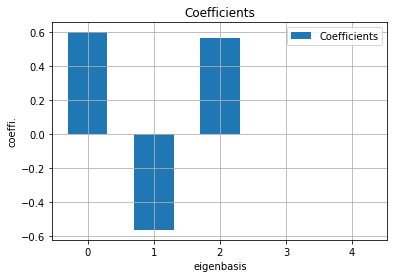

c_0 = 3/5
c_1 = -2*sqrt(2)/5
c_2 = 2*sqrt(2)/5
c_3 = 0
c_4 = 0


In [13]:
# Plot each coefficients

lst_cf = []
for i in range(5):
    lst_cf.append(model.GetCoeff(i))

X = np.arange(len(lst_cf))
Y = np.array(lst_cf)
plt.bar(X, Y, width=0.6, label="Coefficients")
plt.xlabel("eigenbasis")
plt.ylabel("coeffi.")
plt.title("Coefficients")
plt.legend(loc=0)
plt.grid(True)
plt.show()

for i in range(len(lst_cf)):
    print("c_" + str(i) + " = " + str(lst_cf[i]))

[Job Status] Plotting oscillator 0 is finished
[Job Status] Plotting oscillator 1 is finished
[Job Status] Plotting oscillator 2 is finished
[Job Status] Plotting oscillator 3 is finished
[Job Status] Plotting oscillator 4 is finished


<Figure size 432x288 with 0 Axes>

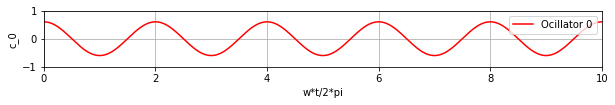

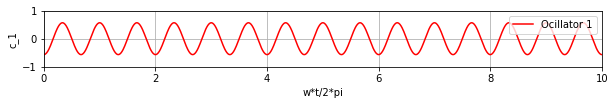

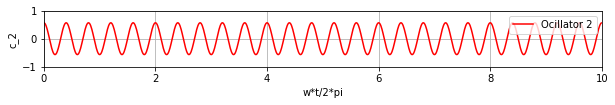

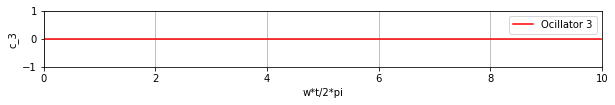

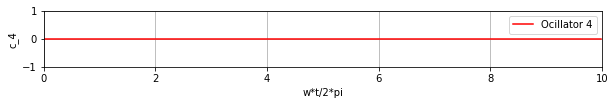

In [14]:
# Plot the time dependence of each oscillators
model.PlotOscillators(5, 10, 'r-')

[Job Status] Plotting ground state finished.
[Job Status] Plotting 5th excited state finished.
[Job Status] Plotting 10th excited state finished.
[Job Status] Plotting 15th excited state finished.


<Figure size 432x288 with 0 Axes>

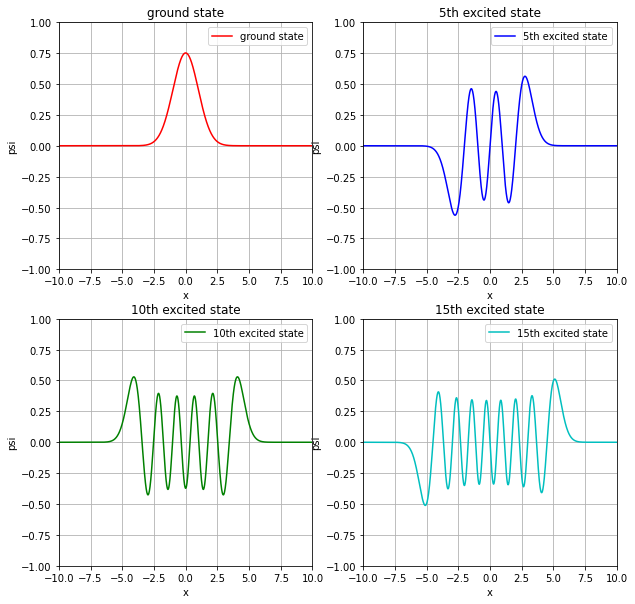

In [15]:
# Example 2
# Plotting basis functions
plt.clf()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
model.PlotBasis(0, 10, "r-", "ground state", "ground state")

plt.subplot(2, 2, 2)
model.PlotBasis(5, 10, "b-", "5th excited state", "5th excited state")

plt.subplot(2, 2, 3)
model.PlotBasis(10, 10, "g-", "10th excited state", "10th excited state")

plt.subplot(2, 2, 4)
model.PlotBasis(15, 10, "c-", "15th excited state", "15th excited state")

# plt.savefig("$PATH/$NAME.png")
plt.show()

In [16]:
# Example 3
# Get the probability
# that a particle can be found
# in the nonclassical region

classic = SHO("")

def GetClassicalProb(n):
    # Get the probability of the particle
    # to be found in the classical region
    # i.e. E_n > V(x) 
    # (n+1/2)*hbar*w > hbar*w*x^2/2
    psi_n = classic.GetBasis(n)
    b = sqrt(2*n + 1)
    print("[Job Info] " + str(n) + ": classical range = (" 
          + str(-b) + ", " + str(b) + ")")
    print("Integrating...")
    prob = integrate(conjugate(psi_n)*psi_n, (x, -b, b))
    prob = prob.subs(pi, 3.14)
    prob = prob.subs(E, 2.71)
    prob = float(prob.evalf())
    return prob
    
def GetNonClassicalProb(n):
    # Get the probability of the particle
    # to be found in the nonclassical region
    # i.e. E_n < V(x) 
    # (n+1/2)*hbar*w < hbar*w*x^2/2
    return 1 - GetClassicalProb(n)

[SHO] 초기설정 시간 좀 걸려요ㅠ
[SHO] SHO is prepared


[Job Info] 0: classical range = (-1, 1)
Integrating...
[Job Status] ground state finished
[Job Info] 1: classical range = (-sqrt(3), sqrt(3))
Integrating...
[Job Status] 1st excited state finished
[Job Info] 2: classical range = (-sqrt(5), sqrt(5))
Integrating...
[Job Status] 2nd excited state finished
[Job Info] 3: classical range = (-sqrt(7), sqrt(7))
Integrating...
[Job Status] 3rd excited state finished
[Job Status] Preparation finished
[Job Status] Plotting...
[Job Status] Plotting finished


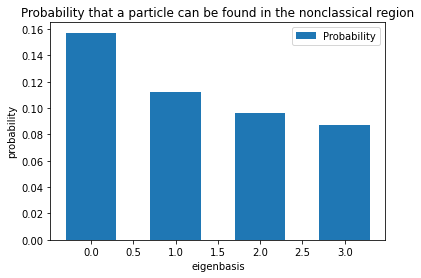

In [17]:
 lst = []
for i in range(4):
    p = GetNonClassicalProb(i)
    lst.append(p)
    job_prefix = "[Job Status] "
    job_suffix = " state finished"
    if i == 0:
        print(job_prefix + "ground" + job_suffix)
    elif i == 1:
        print(job_prefix + "1st excited" + job_suffix)
    elif i == 2:
        print(job_prefix + "2nd excited" + job_suffix)
    elif i == 3:
        print(job_prefix + "3rd excited" + job_suffix)
    else:
        print(job_prefix + str(i) + "th excited" + job_suffix)
print("[Job Status] Preparation finished")

print("[Job Status] Plotting...")
Y = np.array(lst)
X = np.arange(Y.size)
plt.clf()
#plt.figure(figsize(,))
plt.title("Probability that a particle can be found in the nonclassical region")
plt.xlabel("eigenbasis")
plt.ylabel("probability")
plt.bar(X, Y, width=0.6, label='Probability')
plt.legend(loc=0)
# plt.savefig("$PATH/$NAME.png")
print("[Job Status] Plotting finished")
plt.show()